We start by importing necessary packages.

In [62]:
import numpy as np
import scipy as sp
from scipy import linalg, integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Dynamic is given by

$$
\dot y = A \, y + f_l(y) + B \, u, \quad y(0) = y_0.
$$

#### 1. Step: Initialize weights and biases

To approximate the feedback control by a neural network, we choose for example the two-layer network:

$$
\mathcal{F}_\theta(y) = W_2 \,(\sigma(W_1\, y + b_1) + y) - W_2 \, \sigma(b_1)
$$

with $\theta = (W_2, W_1, b_1)$.
Note that the particular structure guarantees $\mathcal{F}_\theta(0) = 0$.

#### 2. Step: Main loop

Forward equation (primal state) is given by

$$
\dot y = f(y) + B \, \mathcal F (y), \quad y(0) = y_0.
$$

Backward equation (adjoint state) is given by

$$
-\dot p = Df^*(y) \, p + D_x \mathcal{F}(y) B^* \, p + Q^* \, Q \, y + \beta\,D_x\mathcal{F}(y)^*\, \mathcal{F}(y) \quad p(T) = 0.
$$

## General functions

$$
\theta_0\, N(y,\theta) + \theta_{2L+2}^T y + 1/2 y^T (\theta_{2L} + \theta_{2L}^T) y + \theta_{2L+1}
$$

In [63]:
class NNWeights(object):
    def __init__(self, L, d, m=1, a=1, seed=0, extended=True, zero_control=True):
        
        self.L = L
        self.d = d
        self.m = m
        
        np.random.seed(seed)        
        WL = np.random.randn(m,d)*a
        self.theta = [WL]
        self.extended = extended
        self.zero_control=zero_control
        
        for l in range(1, self.L):
            Wl = np.random.randn(self.d, self.d)*a
            bl = np.random.randn(self.d)*a

            self.theta.append(Wl)
            self.theta.append(bl)
            
        if self.extended:
            self.theta.append(np.random.randn(self.m, self.d, self.d)*a)    
            self.theta.append(np.random.randn(self.m, self.d)*a)
            self.theta.append(np.zeros(self.m))
            
        if self.extended:
            self.ntheta = 2*self.L + 2
        else:
            self.ntheta = 2*self.L - 1

            
    def get_zeros(self):
        
        WL = np.zeros((self.m, self.d))
        ret = [WL]
        for l in range(1, self.L):
            Wl = np.zeros((self.d, self.d))
            bl = np.zeros(self.d)

            ret.append(Wl)
            ret.append(bl)
            
        if self.extended:
            ret.append(np.zeros((self.m, self.d, self.d)))
            ret.append(np.zeros((self.m, self.d)))
            ret.append(np.zeros(self.m))

        return ret
    
    def __add__(self, x):
            
        if isinstance(x, list):
            return [self.theta[l] + x[l] for l in range(self.ntheta)]
        
        elif isinstance(x, NNWeights):
            return [self.theta[l] + x.theta[l] for l in range(self.ntheta)]

    
    def __iadd__(self, x):
        self.theta = self.__add__(x)
        return self
        
    def __mul__(self, x):
        if isinstance(x, (int, float)):
            return [x * self.theta[l] for l in range(self.ntheta)]
        else:
            raise ValueError
        
    __rmul__ = __mul__
        
    def __imul__(self, x):
        self.theta = self.__mul__(x)
        return self
    
    def __str__(self):
        return str(self.theta)

In [64]:
def l2inner(x, y):
    return np.sum(x * y)

def l2norm(x):
    return np.sqrt(np.sum(np.square(x)))


orig_sigma = 1
if orig_sigma:
    def sigma(y):
        ret = np.zeros_like(y)
        idx = y>0
        ret[idx] = np.power(y[idx], 1.01)
        return ret

    def Dsigma(y):
        ret = np.zeros_like(y)
        idx = y>0
        ret[idx] = 1.01*np.power(y[idx], 0.01)
        return ret
else:
    def sigma(y):
        return np.log(np.exp(y)+np.exp(-y))
    
    def Dsigma(y):
        ep = np.exp(y)
        em = np.exp(-y)
        return (ep-em)/(ep+em)

## Examples

<IPython.core.display.Javascript object>


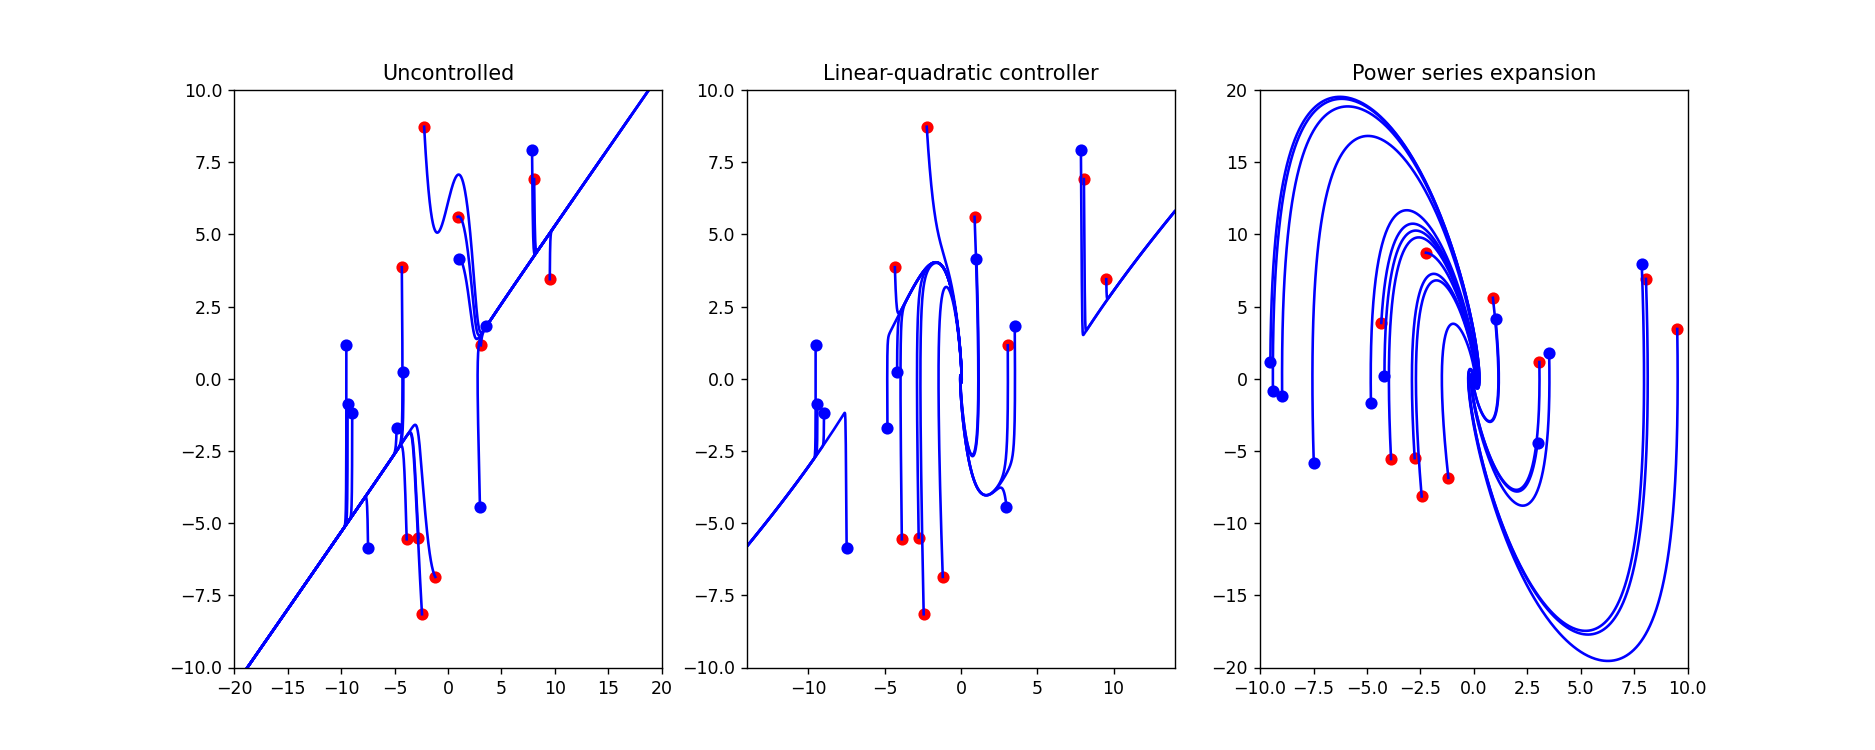

In [98]:
example = 2

# Baseline ode solver
ODESolver = 'BDF'

# Baseline penalty factor and functions
penfac = 1e1
def Dupenalty(y):
    return 0
def Dypenalty(y):
    return 0

# Baseline regularization parameter
alpha = 0.01

if example == 1: # LC-Circuit
    
    A = np.array([[0, 1, -1], [-1, 0, 0], [1, 0, 0]], dtype=np.float64)
    B = np.array([[0], [1], [0]],dtype=np.float64)
    Q = np.eye(3, dtype=np.float64)
    beta = 0.1
    R = beta #*np.eye(3, dtype=np.float64)
    
    
    m = 1 # Control dimension
    d = 3 # State dimension
    
    Ytrain = np.array([[1, 0, 0]], dtype=np.float64)
    Yval = np.array([[-1, 2, 1 ]], dtype=np.float64)
    
    # Final time
    T = 20
    
    # Number of layers
    L = 1
    
    
    # Error level for ode solver
    eps = 1e-13
    ODESolver='RK45'
    
    # Optimal solution obtained by linear-quadratic controller
    Pi = sp.linalg.solve_continuous_are(a=A, b=B, q=Q, r=R)
    Wstar = -1./beta * B.T @ Pi

    def ustar(y):
        return Wstar@y

    def fun(t, y):
        return A @ y + B @ ustar(y)
    
    # Nonlinear part of dynamics
    def f_l(y):
        return np.zeros(d)
                         
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.zeros((d,d))
    
    # Determine explicit solution of first validation point
    tspace = np.linspace(0, T, 2001)
    sol = sp.integrate.solve_ivp(fun, (0,T), Yval[0],
                             method='BDF',
                             rtol=eps, atol=eps, t_eval=tspace)
    
    # Next, we plot the norm of the solution as well as the control
    def solfunc(sol):
        return np.sum(np.square(Q@sol.y),axis=0)
    sol_normsquared=solfunc(sol)

    Ustar = ustar(sol.y).flatten()

    fig, ax = plt.subplots(1,2)
    ax[0].plot(tspace, np.log(sol_normsquared))
    ax[0].set_title('Log of squared norm of $y$: $\log(|Qy(t)|^2)$')
    ax[0].set_xlabel('$t$')
    ax[1].plot(tspace, Ustar)
    ax[1].set_title('Control value $u(t)$')
    ax[1].set_xlabel('$t$');
    
    print('Optimal weights: ', Wstar)
    
    
if example == 2: # Van-der-Pol system
    
    
    m = 1 # Control dimension
    d = 2 # State dimension
    L = 1 # Number of neural network layers
    L = 2
    
    ODESolver = 'BDF'
    penfac = 1e1
    alpha=1.0
    
    def Dupenalty(y):
        return 0
    
    def Dypenalty(y):
        return 0
    
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10,-10]),np.array([10,10]),size=(2*N,2))
    Ytrain = Y[:N]
    Yval = Y[N:]


    fig, axs = plt.subplots(1, 3, figsize=[15,6])
    for ax in axs:
        ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
        ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')


    # Determine uncontrolled orbits
    T = 3
    tspace = np.linspace(0, T, 1001)
    eps = 1e-6

    A = np.array([[0, 1], [-1, 1.5]], dtype=np.float64)
    B = np.array([[0], [1]],dtype=np.float64)
    Q = np.array([[1, 0], [0, 0]], dtype=np.float64)
    beta = 0.001
    R = beta


    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([0, -1.5*(y[0]**2)*y[1] + 0.8*y[0]**3])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0], [-3*y[0]*y[1]+2.4*y[0]**2, -1.5*y[0]**2]])

    def fun_uncontrolled(t, y):
        return A @ y + f_l(y)

    Pi = sp.linalg.solve_continuous_are(a=A, b=B, q=Q, r=R)
    Wstar = -1./beta * B.T @ Pi

    def F_LQR(y):
        tmp =  -1./beta * B.T @ Pi @y
        return tmp

    def fun_LQR(t, y):
        return fun_uncontrolled(t, y) + B @ F_LQR(y)

    M = np.linalg.inv(A.T - 1./beta * Pi @ B @ B.T)

    def F_PSE(y):
        return -1./beta * B.T @ ( Pi @ y -  M @ Pi @ f_l(y))

    def fun_PSE(t, y):
        return fun_uncontrolled(t, y) + B @ F_PSE(y)

    sol_unc = []
    sol_LQR = []
    sol_PSE = []
    for i in range(20):
        yi_0 = Y[i]
        sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[0].plot(sol.y[0], sol.y[1], color='b')
        sol_unc.append(sol)

        sol = sp.integrate.solve_ivp(fun_LQR, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[1].plot(sol.y[0], sol.y[1], color='b')
        sol_LQR.append(sol)

        sol = sp.integrate.solve_ivp(fun_PSE, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[2].plot(sol.y[0], sol.y[1], color='b')
        sol_PSE.append(sol)

    axs[0].set(xlim=(-20,20),ylim=(-10,10))
    axs[0].set(title='Uncontrolled')
    axs[1].set(xlim=(-14,14),ylim=(-10,10))
    axs[1].set(title='Linear-quadratic controller')
    axs[2].set(xlim=(-10,10),ylim=(-20,20));
    axs[2].set(title='Power series expansion');
    
if example == 3: # Collision
    
    
    m = 2 # Control dimension
    d = 2 # State dimension
    L = 1
    ODESolver = 'BDF'
    
    penfac = 1e1
    alpha = 1e-3
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10,-7]),np.array([-6,7]),size=(2*N,2))
    Ytrain = Y[:N]
    Yval = Y[N:]
    
    A = np.array([[0, 0], [0, 0]], dtype=np.float64)
    B = np.array([[1, 0], [0, 1]],dtype=np.float64)

    # State cost
    Q = np.array([[1, 0], [0, 1]], dtype=np.float64)

    # Control cost parameter
    beta = 1.

    # Final time
    T = 10
    tspace = np.linspace(0, T, 1001)
    
    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([0, 0])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0], [0,0]])
    
    # Error level for ode solver
    eps = 1e-6
    
    # Plot of training and test set
    fig, ax = plt.subplots(1, 1, figsize=[15,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')
    
    # Radius of obstacle
    rad = 1.
    c = np.array([-2.5,.0])

    def ypenalty(y):
        dsq = np.sum(np.square(y-c))
        return np.exp(-1/(rad**2-dsq)) if dsq < rad**2 else 0

    def Dypenalty(y):
        dsq = np.sum(np.square(y-c))
        if dsq < rad**2:
            ret = np.exp(-1/(rad**2 - dsq))
            ret *= np.power(rad**2 - dsq, -2)
            ret *= (-2) * (y-c)
            return ret
        else:
            return np.zeros_like(y)

if example == 4:
    m = 2 # Control dimension
    d = 5 # State dimension
    L = 5
    
    ODESolver = 'RK45'
    
    pi = np.pi
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10, -4, -pi/8, 0., 0]),np.array([-8, 4, pi/8, 1., 0]),size=(2*N,d))
    Ytrain = Y[:N]
    Yval = Y[N:]
    
    A = np.zeros((5,5), dtype=np.float64)
    B = np.array([[0, 0], [0, 0], [0, 0], [1, 0], [0, 1]],dtype=np.float64)

    # State cost
    Q = np.zeros((d, d), dtype=np.float64)
    Q[0,0] = 1 # State x
    Q[1,1] = 1 # State y
    Q[3,3] = 1 # Velocity
    
    #Q[2,2] = 1 # Yaw angle
    #Q[4,4] = 1 # Steering angle

    # Control cost parameter
    beta = 0.001

    # Final time
    T = 10
    tspace = np.linspace(0, T, 1001)
    
    Lc = 1 # Distance rear/front axle
    
    deltamax = pi/8
    wdeltamax = .2
    amax = 3.
                
    def ypenalty(y):
        return .5*(np.maximum(np.abs(y[4])-deltamax, 0))**2
    
    def Dypenalty(y):
        return np.maximum(np.abs(y[4])-deltamax, 0)
    
    def upenalty(u):
        p_a = .5*(np.maximum(np.abs(u[0])-amax, 0))**2
        p_wdelta = .5*(np.maximum(np.abs(u[1])-wdeltamax, 0))**2
        return p_a + p_wdelta
    
    def Dupenalty(u):
        p_a = np.maximum(np.abs(u[0])-amax, 0)
        p_wdelta = np.maximum(np.abs(u[1])-wdeltamax, 0)
        return np.array([p_a, p_wdelta])
        
    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([y[3] * np.cos(y[2]),
                         y[3] * np.sin(y[2]),
                         y[3] / Lc * np.tan(y[4]),
                         0,
                         0])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0, -y[3] * np.sin(y[2]), np.cos(y[2]), 0],
                         [0, 0, y[3] * np.cos(y[2]), np.sin(y[2]), 0],
                         [0, 0, 0, np.tan(y[4])/Lc, y[3]/Lc * (1+np.tan(y[4])**2)],
                         [0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0]])
    
    # Error level for ode solver
    eps = 1e-6
    
    # Plot of training and test set
    fig, ax = plt.subplots(1, 1, figsize=[15,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')


## Neural net

In [99]:
# Function class representing feedback laws
def F(Theta, y):

    L = Theta.L
    d = Theta.d
    
    # Forward sweep
    a = y
    if Theta.zero_control:
        a0 = np.zeros_like(y)

    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z = Wl @ a + bl
        a = sigma(z) + a

        if Theta.zero_control:
            z0 = Wl @ a0 + bl
            a0 = sigma(z0) + a0

    WL = Theta.theta[0]

    z = WL @ a
    a = z
    
    # TODO Dim von allen Einzeltermen checken (m-dim)

    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        #a += 0.5 * (y @ (Q+Q.T))@y
        B = Wq + Wq.transpose(0,2,1)
        a += 0.5 * (B @ y) @ y

        b = Theta.theta[2*L]
        a += b@y

        a += Theta.theta[2*L+1]

    if Theta.zero_control:
        z0 = WL @ a0
        a0 = z0
        if Theta.extended:
            a0 += Theta.theta[2*L+1]

    return a - a0 if Theta.zero_control else a

def DxF(Theta, y):

    a = y

    L = Theta.L
    d = Theta.d

    ret = np.eye(d)

    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z = Wl @ a + bl
        ret = (np.diag(Dsigma(z)) @ Wl + np.eye(d)) @ ret

    WL = Theta.theta[0]
    ret = WL @ ret

    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        yv = y.reshape((d,1))
        # TODO Check transposition
        B = Wq + Wq.transpose(0,2,1)
        ret += 0.5*((B@yv).reshape(m, d)+(yv.T @ B).reshape(m, d)).reshape(m,d)

        #ret += (Q+Q.T) @ y
        ret += Theta.theta[2*L]

    return ret

def DthetaF(Theta, y):
    # Order of theta
    # theta = [W_L, W_1, b_1, W_2, b_2, ..., W_{L-1}, b_{L-1}]
    d = Theta.d
    L = Theta.L
    m = Theta.m

    # Forward pass
    a = [y]
    z = []

    if Theta.zero_control:
        a0 = [np.zeros_like(y)]
        z0 = []
        
    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z.append(Wl @ a[-1] + bl)
        a.append(sigma(z[-1]) + a[-1])

        if Theta.zero_control:
            z0.append(Wl @ a0[-1] + bl)
            a0.append(sigma(z0[-1]) + a0[-1])

    WL = Theta.theta[0]

    z.append(WL @ a[-1])
    a.append(z[-1])

    retval = z[-1]
    
    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        B = Wq + Wq.transpose(0,2,1)
        retval += 0.5 * (B @ y) @ y
        #retval += 0.5 * (y @ (Q+Q.T))@y

        b = Theta.theta[2*L]
        retval += b@y

        retval += Theta.theta[2*L+1]

    if Theta.zero_control:
        z0.append(WL @ a0[-1])
        a0.append(z0[-1])
        
        retval -= z0[-1]
        
        if Theta.extended:
            retval -=  Theta.theta[2*L+1]

    # Backward pass
    Ret = [None]*(m)
    for j in range(m):
        ret = [None]*(Theta.ntheta)
        #ret[0] = (a[-2] - a0[-2]).reshape((1,d))
        ret[0] = np.zeros((m,d))

        if Theta.zero_control:
            ret[0][j,:] = a[-2] - a0[-2]
        else:
            ret[0][j,:] = a[-2]

        #ret[0] = np.tile(a[-2] - a0[-2], [m,1])
        delta = WL[j:j+1, :]
        delta0 = WL[j:j+1, :]

        for l in range(1,L):
            Ds = np.diag(Dsigma(z[-1-l]))
            deltaW = delta @ Ds
            DWlF = deltaW.T @ a[-2-l].reshape((1,d))

            if Theta.zero_control:
                Ds0 = np.diag(Dsigma(z0[-1-l]))
                deltaW0 = delta0 @ Ds0
                DWlF -= deltaW0.T @ a0[-2-l].reshape((1,d))
                
            if Theta.extended:
                ret[-2*l-3] = DWlF
            else:
                ret[-2*l] = DWlF

            DblF = deltaW.flatten()

            if Theta.zero_control:
                DblF -= deltaW0.flatten()
                
            if Theta.extended:
                ret[-2*l-2] = DblF
            else:
                ret[-2*l+1] = DblF
            
            if Theta.extended:
                Wl = Theta.theta[-2*l-3]
            else:
                Wl = Theta.theta[-2*l]
                
            delta = delta @ (Ds @ Wl + np.eye(d))

            if Theta.zero_control:
                delta0 = delta0 @ (Ds0 @ Wl + np.eye(d))

        if Theta.extended:
            ret[2*L-1] = np.tile(np.tensordot(y, y, 0), (m, 1, 1))
            ret[2*L] = y
            if Theta.zero_control:
                ret[2*L+1] = np.zeros(1)
            else:
                ret[2*L+1] = np.ones(1)
            
        Ret[j] = ret

    return Ret, retval

## Derived functions

In [100]:
# Forward equations - State

def f(y):
    return A @ y + f_l(y)

def Df(y):
    return A + Df_l(y)

# State equation
def fun_state(t, y, Theta):
    return f(y) + B @ F(Theta, y)

# State equation solver
def solve_state(yi_0, Theta):
    return sp.integrate.solve_ivp(
        fun_state, (0,T), yi_0,
        method=ODESolver,
        rtol=eps,
        atol=eps,
        dense_output=True,
        args=(Theta,))

# Backward equations - Adjoint state

# Adjoint equation
def fun_adjoint(t, p, yi, Theta):
    
    y = yi.sol(T-t)
    tmp = DxF(Theta, y)
    Fy = F(Theta, y)
    Dupen = Dupenalty(Fy)

    t1 = Df(y).T @ p
    t2 = tmp.T @ (B.T @ p + beta * Fy + penfac * Dupen)
    t3 = Q.T @ Q @ y # State cost
    t4 = penfac * Dypenalty(y) # y penalty
    
    ret = t1 + t2 + t3 + t4
    
    return ret

# Hierüber könnte eventuell eine Endbedingung eingehen
def adj_initial(y):
    return np.zeros(d)

# Adjoint state equation solver
def solve_adjoint(yi, Theta):
    return sp.integrate.solve_ivp(
        fun_adjoint, (0,T), adj_initial(yi.sol(T)),
        method=ODESolver,
        rtol=eps,
        atol=eps,
        dense_output=True,
        args=(yi, Theta))

# Gradient equation
def integrate_gradient(yi, pi, Theta):
    
    # Wenn ich hier mit t_eval in state und adjoint equation
    # arbeite, könnte das schneller gehen.
    # Eventuell reicht auch ein kleineres K
    K = 200
    tspace = np.linspace(0, T, K + 1)
    dt = tspace[1]-tspace[0]
    val = Theta.get_zeros()
    L = Theta.L
    
    t = tspace[0]
    
    def theta_val(t):
        y = yi.sol(t)
        p = pi.sol(T-t)
        
        a, Fy = DthetaF(Theta, y)
        b = B.T @ p + beta * Fy
        
        # Das könnte noch effizienter gehen
        ret = [a[0][l] * b[0] for l in range(Theta.ntheta)]
        for i in range(1,m):
            ret = [ret[l] + a[i][l] * b[i] for l in range(Theta.ntheta)]
            
        return ret
    
    valleft = theta_val(t)
    for i in range(K):
        valright = theta_val(tspace[i+1])
        val = [val[l] + dt * .5 * (valleft[l] + valright[l]) for l in range(Theta.ntheta)]
        valleft = valright
    
    # Penalty terms
    # Einfluss von alpha untersuchen
    if Theta.L > 1:
        for i in range(0, Theta.L - 1):

            val[1 + 2*i] += 2 * alpha * Theta.theta[1 + 2*i]
    
    return val

def vec(x):
    ret = np.array(x[0].flatten())
    for i in range(1,len(x)):
        ret = np.append(ret, x[i].flatten())
    return ret

### Check derivative w.r.t. spatial coordinate $y$

In [101]:
#theta = gen_theta(L=L, a=0.1, seed=3)
Theta = NNWeights(L=L, d=d, m=m, a=0.1, seed=3, extended=True, zero_control=True)
y = Yval[0]
Dx = DxF(Theta, y)
h = 1e-8

for i in range(d):
    e = np.zeros(d)
    e[i] = 1
    Dx2 = (F(Theta, y+h*e) - F(Theta, y))/h
    for k in range(m):
        print('Difference: ', Dx[k][i] - Dx2[k])

# Print Dx
print('\n', Dx)
print('DxF in point zero:', DxF(Theta, np.zeros(Theta.d)))
print('F in point zero:', F(Theta, np.zeros(Theta.d)))

Difference:  -1.94932958663685e-11
Difference:  -1.4014146509921943e-08

 [[-0.38691521  1.67347379]]
DxF in point zero: [[0.26699465 0.21460829]]
F in point zero: [0.]


In [102]:
import copy
#y[0] = -100
grad,_ = DthetaF(Theta, y)
h=1e-9
for k in range(m):
    for l in range(2*Theta.L-1):
        print('-----\n', grad[k][l])

        if (l== 0):
            for i in range(m):
                for j in range(d):
                    tplus = copy.deepcopy(Theta)
                    tplus.theta[l][i,j] += h
                    print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        
        elif (l%2 == 1):
            for i in range(d):
                for j in range(d):
                    tplus = copy.deepcopy(Theta)
                    tplus.theta[l][i,j] += h
                    print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))

        else:
            for i in range(d):
                tplus = copy.deepcopy(Theta)
                tplus.theta[l][i] += h
                print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        print('-----\n')
    if Theta.extended:
        
        print('-----\nQuadratic part: ', grad[k][2*Theta.L-1])
        for i in range(d):
            for j in range(d):
                tplus = copy.deepcopy(Theta)
                tplus.theta[2*Theta.L-1][k,i,j] += h
                print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
                
        print('-----\nLinear part: ', grad[k][2*Theta.L])
        for i in range(d):
            tplus = copy.deepcopy(Theta)
            tplus.theta[2*Theta.L][k][i] += h
            print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
            
        print('-----\nBias part: ', grad[k][2*Theta.L+1])
        tplus = copy.deepcopy(Theta)
        tplus.theta[2*Theta.L+1] += h
        print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        
print('\nGrad:\n\n', grad)

-----
 [[-4.32949836  3.86275837]]
-4.329498093369465
3.8627585574602104
-----

-----
 [[0. 0.]
 [0. 0.]]
0.0
0.0
0.0
0.0
-----

-----
 [0. 0.]
0.0
0.0
-----

-----
Quadratic part:  [[[ 18.74455609 -16.72380603]
  [-16.72380603  14.9209022 ]]]
18.74455612949077
-16.723807227947415
-16.723807227947415
14.92090184740391
-----
Linear part:  [-4.32949836  3.86275837]
-4.329498093369465
3.8627585574602104
-----
Bias part:  [0.]
0.0

Grad:

 [[array([[-4.32949836,  3.86275837]]), array([[0., 0.],
       [0., 0.]]), array([0., 0.]), array([[[ 18.74455609, -16.72380603],
        [-16.72380603,  14.9209022 ]]]), array([-4.32949836,  3.86275837]), array([0.])]]


## Main loop

In [113]:
restart = 1

In [127]:
from time import time

converged = False
max_iter = 120000



if restart:
    k = 0   

    if example == 1:
        zero_control=1
        extended=0
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=2, extended=extended, zero_control=zero_control)
        Theta.theta[0] *= 0.
        smin=1e-3
        smax=1e-1
        Yt=Ytrain
        
    elif example == 2:
        
        extended = 0
        zero_control = 1
        if L==1:
            Theta = NNWeights(L=L, d=d, m=m, a=0.0, seed=3, extended=extended, zero_control=zero_control)
            smin = 0.1
            smax = 2.
            fac = 1.
            
            if extended:
                smin = 0.0001
                smax = 0.001
            
        else:
            Theta = NNWeights(L=L, d=d, m=m, a=0.0001, seed=3, extended=extended, zero_control=zero_control)
            smin = 0.01
            smax = 0.05
            fac = 1.
            
        Yt = Ytrain*fac
        
    elif example == 3:
        zero_control=1
        extended=1
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=3, extended=extended, zero_control=zero_control)
        smin = 0.000001
        smax = 0.00001
        
    elif example == 4:
        smin = 0.00000001
        smax = 0.0000001
        L = 3
        zero_control=1
        extended=0
        Yt = Ytrain
        
    else:
        zero_control=1
        extended=0
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=2, extended=extended, zero_control=zero_control)
    
N = Yt.shape[0]
while not converged:
    #print('Iteration:', k, end=' ')
    t = time()
    
    # Initialize gradient update
    Dtheta = NNWeights(L=L, d=d, m=m, a=0, extended=extended, zero_control=zero_control)
    # Loop over traning set
    nsamp = 0
    for i in range(N):
        print('.', end='')
        yi_0 = Yt[i]
        
        # Solve state equation for training set
        yi = solve_state(yi_0, Theta)
        
        # Solve adjoint equation for training set
        pi = solve_adjoint(yi, Theta)
        if yi.success & pi.success:
            nsamp += 1
        
            # Update gradient update
            dthetai = integrate_gradient(yi, pi, Theta)
            Dtheta += dthetai
            #[dtheta[l] + dthetai[l] for l in range(2*L-1)]
        else:
            print('Discarded run {}'.format(i))
            print('yi:', yi.message)
            print('pi:', pi.message)
    if nsamp > 0:
        #Dtheta.theta = [Dtheta.theta[l] / nsamp for l in range(2*L-1)]
        Dtheta *= 1/nsamp
    else:
        print('No valid trajectory computed!')
        converged = True
        #print('dtheta: ', dtheta)
    #converged=True
    #break
    print('')
    #print(dtheta)
    #break
    
        
    # Choose stepsize
    if k < 5:
        s = smin
        
    else:
        Ekm1 = vec(Dtheta.theta) - vec(dthetaold)
        Skm1 = vec(Theta.theta) - vec(thetaold)
        S1BB = l2inner(Skm1, Ekm1) / l2inner(Skm1, Skm1)
        S2BB = l2inner(Ekm1, Ekm1) / l2inner(Skm1, Ekm1)
        s1 = np.maximum(smin, np.minimum(S1BB, smax))
        s2 = np.maximum(smin, np.minimum(S2BB, smax))
        s = s1
        #print('Stepsize s = ', s1, ' or ', s2)

    #print('Stepsize s = ', s)
    if k % 20 == 0:
        print('--------------------------')
        print('Iter  Stepsize  ||dtheta||    nsample     Time')
    grad_theta_norm = l2norm(vec(Dtheta.theta))
    print('{:4d}  {:8.4e}  {:8.4e}      {:3d}    {:8.4f}'.format(k, s, grad_theta_norm, nsamp, time()-t), end='\t')

    #print('Norm of gradient = ', l2inner(dW,dW))
    dthetaold = copy.deepcopy(Dtheta.theta)
    thetaold = copy.deepcopy(Theta.theta)
    # Perform gradient step
    #theta -= s * dtheta
    Theta += (-s) * Dtheta
    #*[theta[l] - s * dtheta[l] for l in range(2*L-1)]
    
    if example == 1:
        if grad_theta_norm < 1e-1:
            smin=10.
            smax=50.
        
    if example == 2:   
        
        if L == 1:
            if np.square(grad_theta_norm) < 1e-0:
                smin=10.
                smax=100.
            if np.square(grad_theta_norm) < 1e-1:
                smin=100.
                smax=1000.
        
        if (grad_theta_norm < 1e-1) & (fac+0.1 < 1-1e-13):
            fac += .1
            Yt = Ytrain*fac
            Theta_save = copy.deepcopy(Theta)
            smin = 0.001
            smax = 0.2
            print('Increase training set radius to {}'.format(fac))
        if False & (grad_theta_norm > 5e1):
            print('Decrease step sizes')
            smax = smax*0.5
            smin = smin*0.5
            Theta = copy.deepcopy(Theta_save)

    #print('Iteration: ', k)
    k = k+1
    if k >= max_iter or grad_theta_norm < 1e-6:
        converged = True
        
#theta_save = copy.deepcopy(theta)

..........
1384  1.0000e-01  3.0455e-01       10      2.0451	..........
1385  1.9255e-02  3.0397e-01       10      1.9233	..........
1386  1.9231e-02  3.0386e-01       10      1.9218	..........
1387  1.9211e-02  3.0374e-01       10      1.9729	..........
1388  1.9204e-02  3.0363e-01       10      1.9182	..........
1389  1.9199e-02  3.0352e-01       10      1.9414	..........
1390  1.9182e-02  3.0341e-01       10      1.9898	..........
1391  1.9199e-02  3.0330e-01       10      1.9866	..........
1392  1.9169e-02  3.0318e-01       10      1.9775	..........
1393  1.9157e-02  3.0307e-01       10      2.0057	..........
1394  1.9146e-02  3.0296e-01       10      2.0101	..........
1395  1.9143e-02  3.0285e-01       10      2.0130	..........
1396  1.9135e-02  3.0274e-01       10      1.9482	..........
1397  1.9120e-02  3.0263e-01       10      1.9364	..........
1398  1.9105e-02  3.0252e-01       10      1.9560	..........
1399  1.9108e-02  3.0241e-01       10      1.9663	..........
-------------

1637  1.7187e-02  2.7972e-01       10      1.9120	..........
1638  1.7175e-02  2.7964e-01       10      1.9185	..........
1639  1.7169e-02  2.7955e-01       10      1.9335	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1640  1.7175e-02  2.7947e-01       10      1.9506	..........
1641  1.7161e-02  2.7939e-01       10      1.9177	..........
1642  1.7132e-02  2.7931e-01       10      1.9206	..........
1643  1.7123e-02  2.7923e-01       10      1.9337	..........
1644  1.7141e-02  2.7914e-01       10      2.0207	..........
1645  1.7118e-02  2.7906e-01       10      2.0464	..........
1646  1.7153e-02  2.7898e-01       10      2.0777	..........
1647  1.7096e-02  2.7890e-01       10      2.0879	..........
1648  1.7111e-02  2.7882e-01       10      2.0742	..........
1649  1.7104e-02  2.7874e-01       10      2.0271	..........
1650  1.7100e-02  2.7865e-01       10      2.0080	..........
1651  1.7102e-02  2.7857e-01       10      1.9768	..........
1652  1.701

1889  1.5673e-02  2.6139e-01       10      2.0699	..........
1890  1.5677e-02  2.6133e-01       10      2.0749	..........
1891  1.5703e-02  2.6126e-01       10      1.9755	..........
1892  1.5625e-02  2.6120e-01       10      1.9742	..........
1893  1.5677e-02  2.6113e-01       10      1.9338	..........
1894  1.5655e-02  2.6107e-01       10      2.0710	..........
1895  1.5644e-02  2.6101e-01       10      1.9445	..........
1896  1.5619e-02  2.6094e-01       10      1.9997	..........
1897  1.5603e-02  2.6088e-01       10      2.0215	..........
1898  1.5661e-02  2.6082e-01       10      2.0004	..........
1899  1.5629e-02  2.6075e-01       10      2.0189	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1900  1.5590e-02  2.6069e-01       10      2.0179	..........
1901  1.5615e-02  2.6062e-01       10      1.9728	..........
1902  1.5628e-02  2.6056e-01       10      1.9698	..........
1903  1.0000e-02  2.6071e-01       10      1.9635	..........
1904  1.852

KeyboardInterrupt: 

## Final output

In [128]:
if example == 1:
    restart = 0
    savefig = False
    
elif example == 2:
    restart = 0
    savefig = False
    poststr = 'new'
    smin = 1e-2
    smax = 1e-1
    plot_comparison = False # Takes some minutes

elif example == 3:
    restart = 0
    savefig = False
    smax = 1e-4
    smin = smax/10
    poststr = 'new'
    
elif example == 4:
    savefig = False
    poststr = 'new'
    restart = 0
    
    smin = 5e-8
    smax = 5e-7

<IPython.core.display.Javascript object>


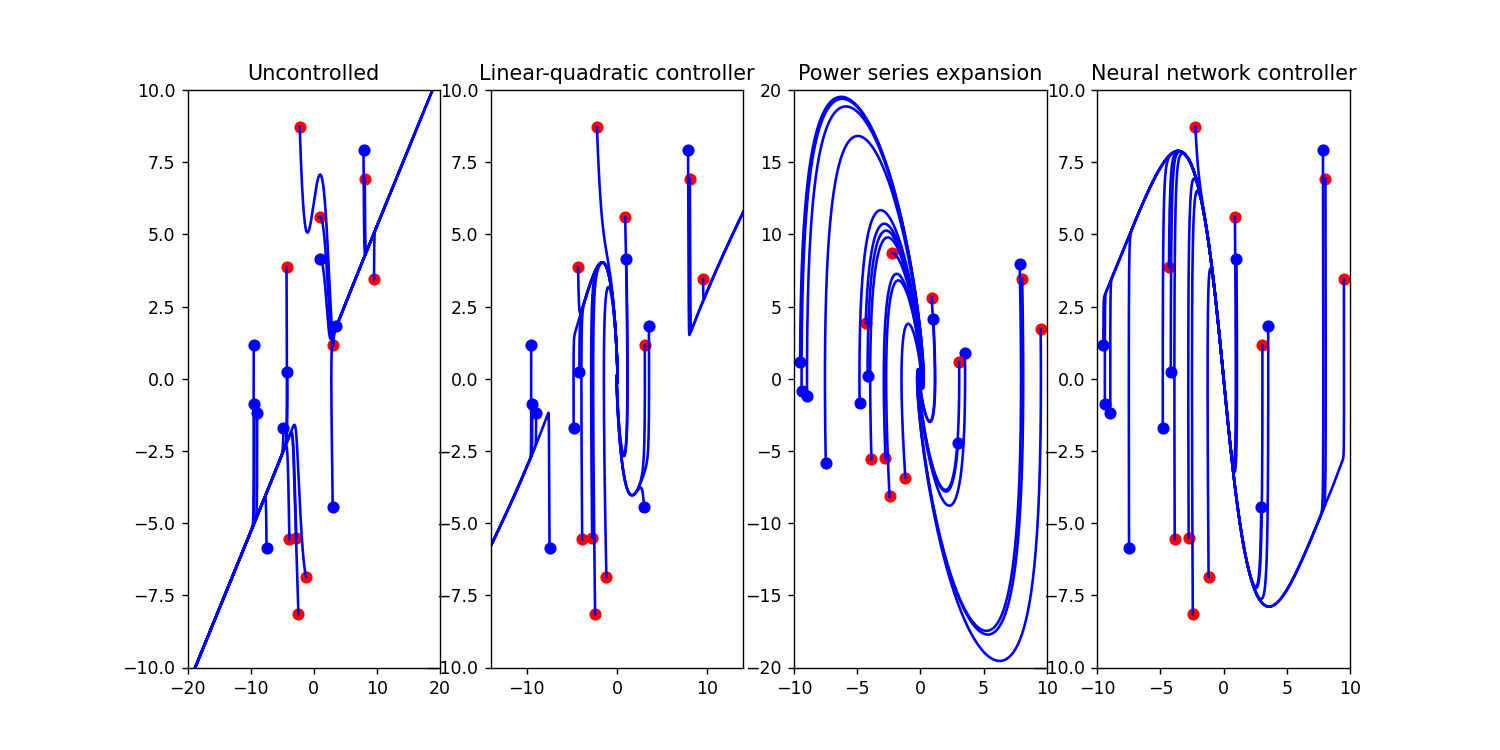

<IPython.core.display.Javascript object>


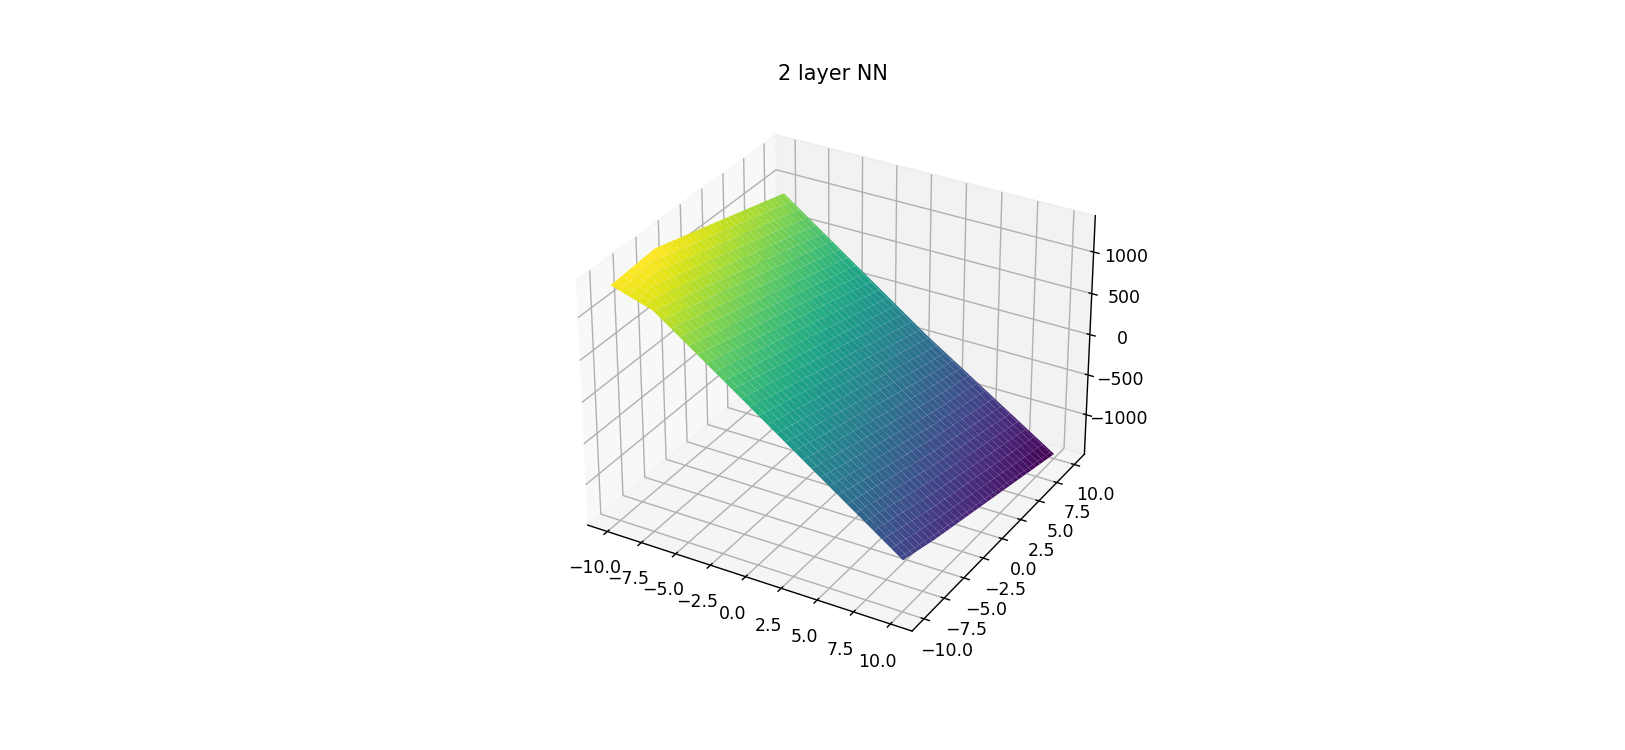

---------------------------------------- 
 Point:  [-7.37 -9.17]
Uncontrolled:
|Qy|: 1492.4852057549904
|F(y)|: 0
J(y,F(y)): 1113756.044698758

LQR:
|Qy|: 739.5039821987712
|F(y)|: 26389.50213476819
J(y,F(y)): 621635.9813043877

PSE:
|Qy|: 3.7840389722552485
|F(y)|: 494.87381131053917
J(y,F(y)): 129.60952003228286

2 layer NN:
|Qy|: 4.779171940642674
|F(y)|: 62.63986912708704
J(y,F(y)): 13.382118821242427
---------------------------------------- 
 Point:  [ 2.04 -4.97]
Uncontrolled:
|Qy|: 220.72797636781021
|F(y)|: 0
J(y,F(y)): 24360.419775714294

LQR:
|Qy|: 0.8524465290271654
|F(y)|: 8.030187259481893
J(y,F(y)): 0.39557449613640366

PSE:
|Qy|: 0.7556289986075667
|F(y)|: 15.741351868633288
J(y,F(y)): 0.4093826710943994

2 layer NN:
|Qy|: 0.7944379335143789
|F(y)|: 62.63986912708704
J(y,F(y)): 2.2774424172325944
---------------------------------------- 
 Point:  [5.81 2.03]
Uncontrolled:
|Qy|: 1158.211303953328
|F(y)|: 0
J(y,F(y)): 670726.7123026343

LQR:
|Qy|: 7.337377712901824
|F(y)|:

<IPython.core.display.Javascript object>


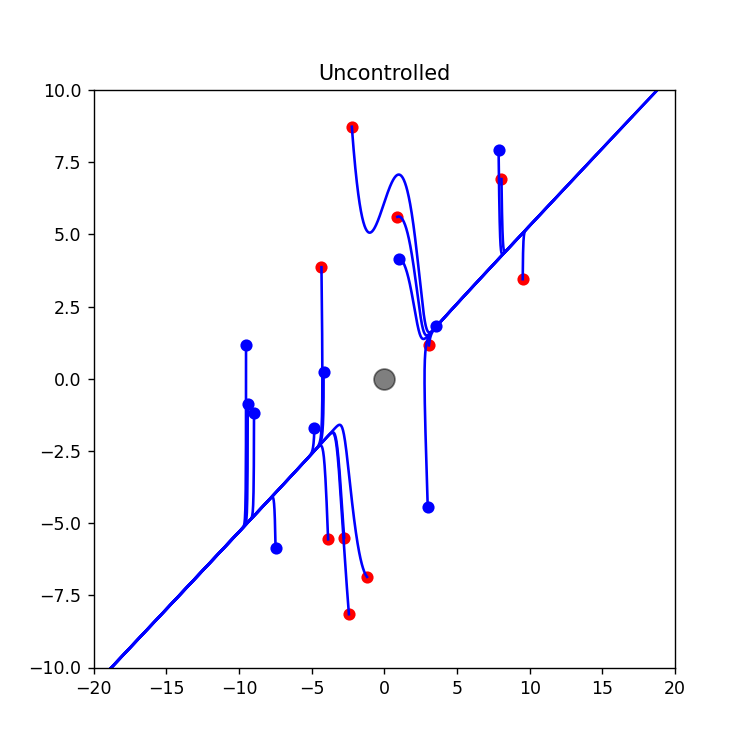

<IPython.core.display.Javascript object>


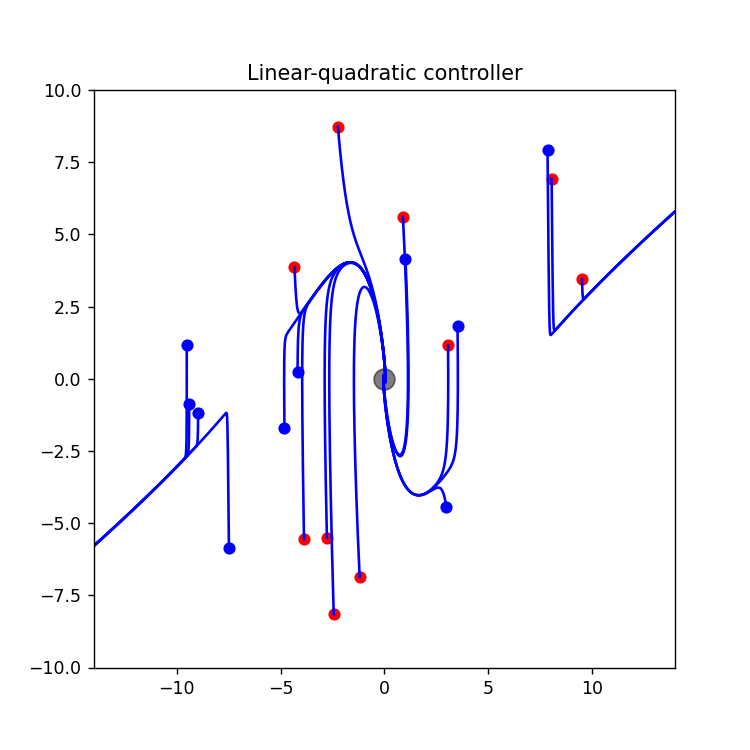

<IPython.core.display.Javascript object>


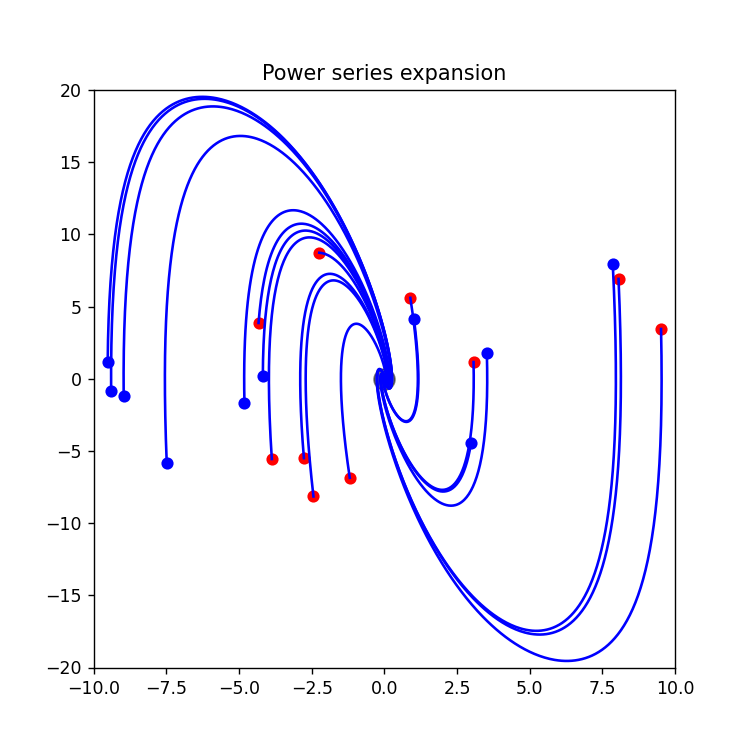

<IPython.core.display.Javascript object>


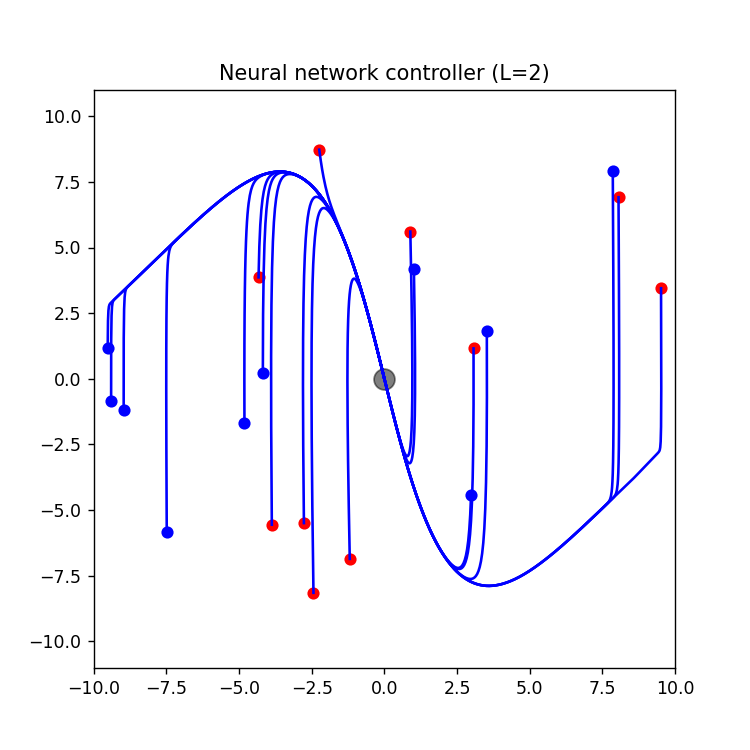

In [129]:
if example == 1:
    print('NN weights', Theta.theta[0])
    print('LQC weights', Wstar)
    
if example == 2:

    sol_NN = []
    for i in range(20):
        yi_0 = Y[i]

        sol = sp.integrate.solve_ivp(fun_state, (0,T), yi_0,
                                     method='BDF',
                                     rtol=eps,
                                     atol=eps,
                                     t_eval=tspace,
                                     args=(Theta,))
        #sol = solve_state(yi_0, theta)
        sol_NN.append(sol)
    fig, axs = plt.subplots(1, 4, figsize=[12,6])
    for ax in axs:
        ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
        ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')

    for i in range(20):
        for j, sol in enumerate([sol_unc, sol_LQR, sol_PSE, sol_NN]):
            axs[j].plot(sol[i].y[0], sol[i].y[1], color='b')

    axs[0].set(xlim=(-20,20),ylim=(-10,10))
    axs[0].set(title='Uncontrolled')
    axs[1].set(xlim=(-14,14),ylim=(-10,10))
    axs[1].set(title='Linear-quadratic controller')
    axs[2].set(xlim=(-10,10),ylim=(-20,20));
    axs[2].set(title='Power series expansion');
    axs[3].set(xlim=(-10,10),ylim=(-10,10));
    axs[3].set(title='Neural network controller');
    
    # Plot control
    y1lin = np.linspace(-10,10,101)
    y2lin = np.linspace(-10,10,101)
    y1, y2 = np.meshgrid(y1lin,y2lin)
    Ym = np.vstack([y1.flatten(),y2.flatten()])
    u_NN = np.array([F(Theta,y) for y in Ym.T])
    u_NN = u_NN.reshape(101,101)
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(y1,y2,u_NN,cmap='viridis')
    ax.set_title('{} layer NN'.format(L));
    
    # Compare results
    for y0 in [np.array([-7.37, -9.17]), np.array([2.04, -4.97]), np.array([5.81, 2.03]), np.array([-3.31, -7.61])]:
        print('-'*40, '\n Point: ', y0)

        Tlong = 10
        tlong = np.linspace(0,Tlong,401)
        dt = tlong[1]-tlong[0]

        sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        def tint(z):
            return np.sqrt(np.sum(np.sum(np.square(z),axis=0))*dt)

        def Jyu(Qyint, Fyint):
            return .5 * Qyint ** 2 + beta/2 * Fyint ** 2

        print('Uncontrolled:')
        Qyint = tint(Q@sol.y)
        Fyint = 0
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))

        sol = sp.integrate.solve_ivp(fun_LQR, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        print('\nLQR:')
        Qyint = tint(Q@sol.y)
        Fyint = tint(F_LQR(sol.y))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))

        sol = sp.integrate.solve_ivp(fun_PSE, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        print('\nPSE:')
        Qyint = tint(Q@sol.y)
        Fyint = tint(np.array([F_PSE(y) for y in sol.y.T]))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))



        sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong, args=(Theta,))
        print('\n{} layer NN:'.format(L))
        Qyint = tint(Q@sol.y)
        Fyint = tint(F(Theta,y))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))
    # Plot paths of uncontrolled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')    
    ax.set(xlim=(-20,20),ylim=(-10,10))
    ax.set(title='Uncontrolled')
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_unc:
        ax.plot(sol.y[0], sol.y[1], color='b')


    if savefig:
        plt.savefig('images/VdP_Paths_uncontrolled_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

    # Plot paths of linearly controlled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')    
    ax.set(xlim=(-14,14),ylim=(-10,10))
    ax.set(title='Linear-quadratic controller')
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_LQR:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_LQR_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

    # Plot paths of PSE controlled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o') 
    ax.set(xlim=(-10,10),ylim=(-20,20));
    ax.set(title='Power series expansion');
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_PSE:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_PSE_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    
    # Plot paths of NN controller
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o') 
    ax.set(xlim=(-10,10),ylim=(-11,11));
    ax.set(title='Neural network controller (L={})'.format(L));

    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_NN:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_NN_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    
    # Plot comparison
    if plot_comparison:
        Tlong = 10
        tlong = np.linspace(0,Tlong,401)
        dt = tlong[1]-tlong[0]

        def tint(z):
            return np.sqrt(np.sum(np.sum(np.square(z),axis=0))*dt)

        def Jyu(Qyint, Fyint):
            return .5 * Qyint ** 2 + beta/2 * Fyint ** 2

        junc = []
        jlqr = []
        jpse = []
        jnn1 = []
        jnn2 = []

        for y0 in Ym.T:
            print(y0)
            sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)

            Qyint = tint(Q@sol.y)
            Fyint = 0
            junc.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_LQR, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)
            Qyint = tint(Q@sol.y)
            Fyint = tint(F_LQR(sol.y))
            jlqr.append(Jyu(Qyint, Fyint))


            sol = sp.integrate.solve_ivp(fun_PSE, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)
            Qyint = tint(Q@sol.y)
            Fyint = tint(np.array([F_PSE(y) for y in sol.y.T]))
            jpse.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong, args=(Theta_lin,))
            Qyint = tint(Q@sol.y)
            Fyint = tint(F(Theta_lin,y))
            jnn1.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong, args=(Theta,))
            Qyint = tint(Q@sol.y)
            Fyint = tint(F(Theta,y))
            jnn2.append(Jyu(Qyint, Fyint))

        # Finally, produce plot
        Junc = np.array(junc).reshape(101,101)
        Jlqr = np.array(jlqr).reshape(101,101)
        Jpse = np.array(jpse).reshape(101,101)

        Jnn1 = np.array(jnn1).reshape(101,101)
        Jnn2 = np.array(jnn2).reshape(101,101)

        Tmp=np.array([jlqr,jpse,jnn1,jnn2])

        fig = plt.figure(figsize=(13,6))
        ax = fig.add_subplot(111)
        #, projection='3d')
        #ax.plot_surface(y1,y2,Jlqr<Jnn1,cmap='viridis')
        cax = ax.imshow(np.argmin(Tmp.T,axis=1).reshape(101, 101), extent=[-10,10,-10,10])
        #, cmap='viridis')
        ax.set_title('Cost optimal controller'.format(L));
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.legend(['test'])
        cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3]);
        cbar.ax.set_yticklabels(['LQR', 'PSE', 'NN-1', 'NN-2']);
        if savefig:
            plt.savefig('images/VdP_Comparison_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
                transparent=True, bbox_inches='tight', pad_inches=0.1)
        
if example == 3:
    def fun_NN(t, y):
        return fun_state(t, y, Theta)

    sol_NN = []
    Ynow = np.vstack([Ytrain,Yval])
    for i,_ in enumerate(Ynow):
        yi_0 = Ynow[i]

        sol = sp.integrate.solve_ivp(fun_NN, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        sol_NN.append(sol)

    fig, axs = plt.subplots(1, 1, figsize=[10,6])
    axs.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    axs.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')
    axs.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for i in range(20):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1], color='b')

    nd = 100
    axs.set(xlim=(-12,2),ylim=(-8,8));
    axs.set(title='{}-layer NN controller'.format(L));
    xc = np.linspace(c[0]-rad,c[0]+rad,nd+1)
    yc = -np.sqrt(rad**2-(xc-c[0])**2)
    axs.fill_between(xc, yc, -yc)
    if savefig:
        plt.savefig('images/Collision_Paths_w_penalty_beta_high_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot control
    y1lin = np.linspace(-10,10,nd+1)
    y2lin = np.linspace(-10,10,nd+1)
    y1, y2 = np.meshgrid(y1lin,y2lin)
    Ym = np.vstack([y1.flatten(),y2.flatten()])
    u_NN = np.array([F(Theta,y) for y in Ym.T])
    u_NN1 = u_NN[:,0].reshape(nd+1,nd+1)
    u_NN2 = u_NN[:,1].reshape(nd+1,nd+1)
    
    if False:
        col = np.array([ypenalty(y) for y in Ym.T])
        u_NN1 = col.reshape(nd+1,nd+1)
    
        col = np.array([Dypenalty(y) for y in Ym.T])
        u_NN1 = col[:,1].reshape(nd+1,nd+1)
        u_NN2 = col[:,1].reshape(nd+1,nd+1)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(y1,y2,u_NN1,cmap='viridis')
    ax.set_title('x Control');
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(y1,y2,u_NN2,cmap='viridis')
    ax.set_title('y Control');
    if savefig:
        plt.savefig('images/Collision_Control_w_penalty_beta_high_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
        
    # Find out time at which state x becomes close to zero
    #sol_NN[1].t[np.where(np.abs(sol_NN[1].y[0])<1e-3)[0][0]]
    
if example == 4:
    
    def fun_NN(t, y):
        return fun_state(t, y, Theta)

    sol_NN = []
    Ynow = np.vstack([Ytrain,Yval])
    for i,_ in enumerate(Ynow):
        yi_0 = Ynow[i]

        sol = sp.integrate.solve_ivp(fun_NN, (0,T), yi_0,
                                 method=ODESolver,
                                 rtol=eps,
                                 atol=eps,
                                 t_eval=tspace)
        sol_NN.append(sol)

    fig, axs = plt.subplots(1, 1, figsize=[10,6])
    axs.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    axs.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')

    # Plot paths training data
    for i in range(N):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1])

        
    axs.set(xlim=(-11,2),ylim=(-5,5));
    axs.set(title='{}-layer NN controller'.format(L));
    axs.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)
    
    if savefig:
        plt.savefig('images/CarModel_Paths_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot paths of validation data
    for i in range(N,2*N):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1])

    if savefig:
        plt.savefig('images/CarModel_Paths_Val_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
        
        
    # Plot state trajectories
    fig, axs = plt.subplots(d, 1, figsize=[5,10])

    Irange = [0,1,2,3]

    for i in range(d):
        for j in range(4):
            axs[i].plot(sol_NN[j].t, sol_NN[j].y[i])

    axs[0].set(xlim=(-.1, 10.1),ylim=(-10,5), ylabel='$x$ position');
    axs[0].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[1].set(xlim=(-.1, 10.1),ylim=(-5,5), ylabel='$y$ position');
    axs[1].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[2].set(xlim=(-.1, 10.1),ylim=(-np.pi, np.pi), ylabel='$\psi$ yaw angle');
    axs[3].set(xlim=(-.1, 10.1),ylim=(-1, 5), ylabel='$v$ velocity');
    axs[3].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[4].set(xlim=(-.1, 10.1),ylim=(-np.pi/2, np.pi/2), ylabel='$\delta$ steering angle');
    axs[4].plot(np.array([0, T]), np.array([deltamax, deltamax]), 'r--', alpha=0.5);
    axs[4].plot(np.array([0, T]), np.array([-deltamax, -deltamax]), 'r--', alpha=0.5);

    if savefig:
        plt.savefig('images/CarModel_State_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot control trajectories
    fig, axs = plt.subplots(m, 1, figsize=[5,4])

    for j in Irange:
        Fy = np.array([F(Theta, y) for y in sol_NN[j].y.T])
        axs[0].plot(sol_NN[j].t, Fy[:,0])
        axs[1].plot(sol_NN[j].t, Fy[:,1])
    axs[0].set(xlim=(-.1, 10.1), ylabel='$a$ acceleration');
    axs[1].set(xlim=(-.1, 10.1), ylabel='$w_\delta$ steering angle velocity');

    if savefig:
        plt.savefig('images/CarModel_Control_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

In [130]:
Theta.theta

[array([[-40.98814789,  15.70549831]]),
 array([[ 1.62837712,  0.9958629 ],
        [-0.64787812, -0.38214931]]),
 array([21.45483622,  4.19695491])]

In [122]:
Theta_save = copy.deepcopy(Theta)

In [126]:
Theta = copy.deepcopy(Theta_save)